# Supplementary code for the paper: 
## "Sifting out the features: are convolutional networks the winning lottery ticket of the fully connected ones?"

This notebook provides supplementary code to analyze and post-process the output of the main Python code.

In [1]:
# Loading modules
%matplotlib inline  
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
import os
import copy

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
  
# Setting the dataset as ImageNet32 or 64
dataset = 'ImageNet32'
# dataset = 'ImageNet64'
N_CLASSES = 10
if dataset=='ImageNet32':
  DDc = 3
  DDh = 32
  DDw = 32
elif dataset=='ImageNet64':
  DDc = 3
  DDh = 64
  DDw = 64

In [2]:
#For larger display
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
# display(HTML("<style>div.cell.selected { border-left-width: 1px !important;}</style>"))

## Visualizing the overall IMP run
The code outputs a file `IMP_findata.pkl` at the end of the run, with a summary of sparsities and best validation.

We will load and visualize that file to get an idea of the run, and decide which iteration to analyze.

In [3]:
# Select the folder of the computation
data_dir = 'fromDT/IMPn22/'
with open(data_dir+'IMP_findata.pkl', 'rb') as f:
  [arch, ratl, mins] = pickle.load(f)
  ratl = np.mean(ratl, axis=1)

Best iteration: 13 with accuracy 12.64%.


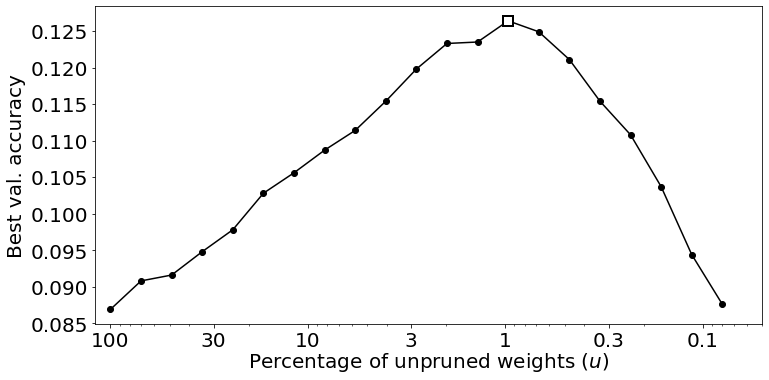

In [4]:
# Plotting the best accuracy as a function of sparsity
fig, ax = plt.subplots(1,1, figsize=(10, 5))
plt.tight_layout()
ax.set_xlabel(r"Percentage of unpruned weights ($u$)", fontsize=20, labelpad=0)
ax.set_ylabel(r"Best val. accuracy", fontsize=20)
ax.set_xscale("log")
ax.set_xlim(1.2,0.0005)
xt = [1e-3,3e-3,1e-2,3e-2,1e-1,3e-1,1]
plt.xticks(xt, ['0.1','0.3','1','3','10','30','100'], fontsize=20)
plt.yticks(fontsize=20)
ax.plot(1-ratl, 1-np.asarray(mins), 'ko-')
# Find max and put a marker there
maxind = np.argmin(mins)
ax.plot(1-ratl[maxind], 1-mins[maxind], 's', ms=10, mew=2, c='k', mfc='w')
print("Best iteration: {} with accuracy {:.2f}%.".format(maxind, 100*(1-mins[maxind])))

## Visualizing a specific iteration
We will now consider a specific iteration. We can either select the best iteration of the run, or choose a specific one.

The code outputs a file `IMP_itdata_X.pkl` for each iteration `X`, containing all the information to analyze the run as done in the paper.

In [5]:
# Set if needed
# data_dir = ''
# NPlot = 14
NPlot = maxind
data_prefix = 'IMP_itdata_'
with open(data_dir+data_prefix+str(NPlot)+'.pkl', 'rb') as f:
  [arch, ratio, Tpoints, sl, sel, tl, el, weil, mvl, ml] = pickle.load(f)
print("Loaded file {}, found iterations: {}".format(data_prefix+str(NPlot),Tpoints))

Loaded file IMP_itdata_13, found iterations: [100000]


### Training error

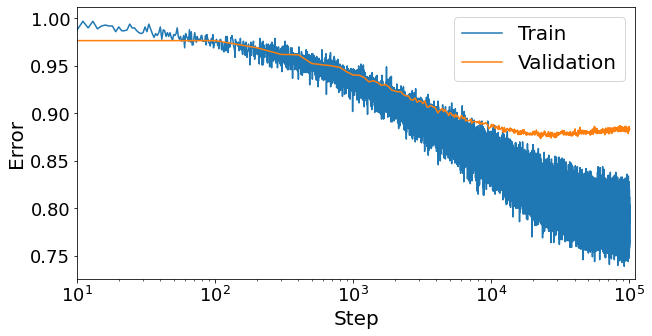

In [6]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.set_xscale("log")
ax.set_xlim(10.0, sl[-1]*1.1)
ax.set_xlabel("Step", fontsize=20)
ax.set_ylabel("Error", fontsize=20)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.plot(sl,tl,'-',label="Train")
ax.plot(sel,el,'-',label="Validation")
ax.legend(fontsize=20)

### Locality
We compute and plot $S^{\rm sc}(\mathbf{d})$ and $S^{\rm dc}(\mathbf{d})$ as defined in the paper.

- The parameters MX and MY allow to define a smaller mask (by default they are the input size, to consider all possible displacements).
- The parameter Nlay (default 1) establishes which hidden layer to consider.
- The cutoff (default 1e7) stops the computation if too many connections are cosidered (mostly the case for high connectivity iterations, but this step can take some time also for fairly sparse layers).

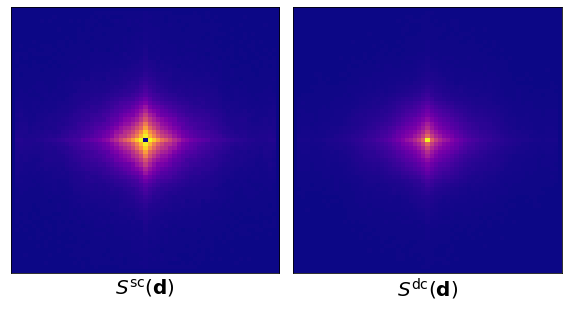

In [7]:
# Params
Nlay = 1
Mx = DDw
My = DDh
cutoff = 1e7

fig, ax = plt.subplots(1,2, figsize=(4*2,4.4))
ax[0].set_xlabel(r"$S^{\rm sc}(\mathbf{d})$", fontsize=20)
ax[1].set_xlabel(r"$S^{\rm dc}(\mathbf{d})$", fontsize=20)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.tight_layout()

cmap = np.zeros((2*Mx+1,2*My+1,3))
mm = ml[0][0]
for l in range(1,Nlay):
  mm = mm@ml[l][0]

nnc = 0
# Iterating over nodes
for rr, spc in enumerate(mm.T):
  indices = np.nonzero(spc)[0]
  li = len(indices)
  if li>1:
    nnc += li**2
    # Get original location
    ys, xs = np.divmod(indices, DDw)
    cs, ys = np.divmod(ys, DDh)
    # Compute x and y differences (with clipping) 
    xdiff = np.clip(xs[:-1,np.newaxis]-xs[np.newaxis,1:],-Mx,Mx)
    ydiff = np.clip(ys[:-1,np.newaxis]-ys[np.newaxis,1:],-My,My)
    cldiff = cs[:-1,np.newaxis]-cs[np.newaxis,1:]
    # For each i only get j>i and fill the other too
    for ii in range(li-1):
      for dx, dy, dc in zip(xdiff[ii,ii:],ydiff[ii,ii:],cldiff[ii,ii:]):
        cmap[dy+My,dx+Mx,dc] += 1
        cmap[-dy+My,-dx+Mx,-dc] += 1
  if nnc>cutoff:
      break
      
# Normalize and plot
scmax = np.max(cmap[:,:,0])
dcmax = np.max(np.sum(cmap[:,:,1:3],axis=2))
ax[0].imshow(cmap[:,:,0], aspect='auto', interpolation='none', cmap='plasma', vmin=0, vmax=scmax)
ax[1].imshow(cmap[:,:,1]+cmap[:,:,2], aspect='auto', interpolation='none', cmap='plasma', vmin=0, vmax=dcmax)

### Number of connections

Histogram of nodes with a given number of connections.

- The parameter Nlay (default 1) establishes which hidden layer to consider.
- The parameter Bwid (default 2) indicates the width of the bins in number of connections.

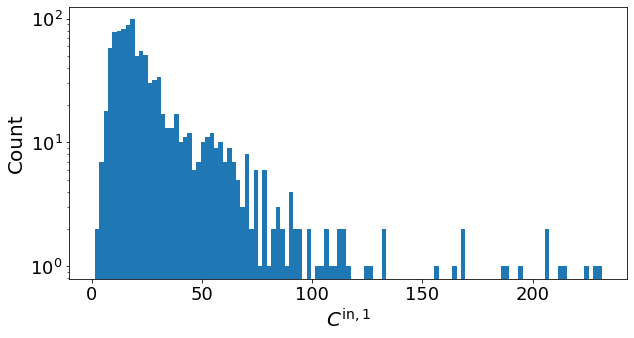

In [8]:
#Params
Nlay = 1
Bwid = 2

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.set_yscale("log")
ax.set_xlabel(r'$C^{{\rm in, {{{}}}}}$'.format(Nlay), fontsize=20)
ax.set_ylabel("Count", fontsize=20)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)

mm = ml[0][0]
for l in range(1,Nlay):
  mm = mm@ml[l][0]

Nnei = [len(np.nonzero(spc)[0]) for spc in mm.T]
minb = np.min(Nnei)
maxb = np.max(Nnei)
_, _, _ = ax.hist(Nnei, bins=np.arange(minb,maxb+Bwid,Bwid)-Bwid+0.5, density=False)

### Connection resolved locality
We compute and plot $S^{\rm sc}(\mathbf{d})$ and $S^{\rm dc}(\mathbf{d})$ but restricted to nodes with a given number of unpruned connections.
It is useful to look at the previous histogram when setting parameters for this plot.

- The parameters MX, MY, Nlay and cutoff are the same as the plot above.
- Npl is the total number of graphs to be plotted
- cstep is the number of connections to put in every plot (the last one will contain all remaining nodes)
- Ncols the number of columns to organize the plots in (defaults to Npl/2)
- S2p indicates whether to plot $S^{\rm sc}(\mathbf{d})$ (0, default) or $S^{\rm dc}(\mathbf{d})$ (1)

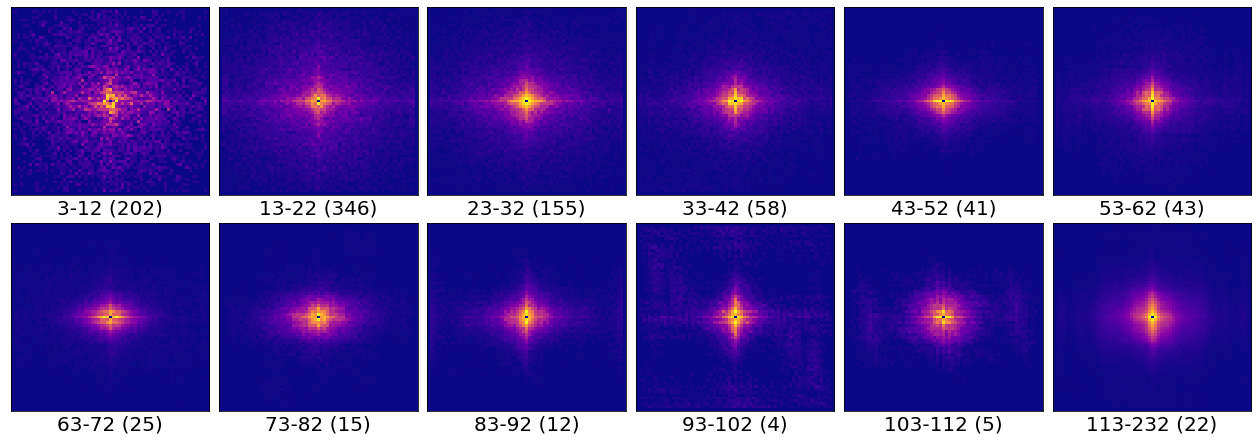

In [9]:
# Params
Nlay = 1
Mx = DDw
My = DDh
cutoff = 1e7
Npl = 12
cstep = 10
Ncols = int(np.ceil(Npl/2))
S2p = 0

Nrows = int(np.ceil(Npl/Ncols))
SIZE = 3
fig, ax = plt.subplots(Nrows,Ncols, figsize=(SIZE*Ncols, (SIZE+0.1)*Nrows))
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.15)

mm = ml[0][0]
for l in range(1,Nlay):
  mm = mm@ml[l][0]
Nnei = [len(np.nonzero(spc)[0]) for spc in mm.T]
cmin = np.maximum(np.min(Nnei),2)
cmax = np.max(Nnei)

for i in range(Npl):
  cmap = np.zeros((2*Mx+1,2*My+1,3))
  if i<Npl-1:
    indz = np.where((Nnei>cmin+i*cstep)&(Nnei<cmin+(i+1)*cstep))[0]
  else:
    indz = np.where(Nnei>cmin+i*cstep)[0]
  if len(indz)>0:
    nnc = 0
    for rr, spc in enumerate(mm[:,indz].T):
      indices = np.nonzero(spc)[0]
      li = len(indices)
      if li>1:
        nnc += li**2
        # Get original location
        ys, xs = np.divmod(indices, DDw)
        cs, ys = np.divmod(ys, DDh)
        # Compute x and y differences (with clipping) 
        xdiff = np.clip(xs[:-1,np.newaxis]-xs[np.newaxis,1:],-Mx,Mx)
        ydiff = np.clip(ys[:-1,np.newaxis]-ys[np.newaxis,1:],-My,My)
        cldiff = cs[:-1,np.newaxis]-cs[np.newaxis,1:]
        # For each i only get j>i and fill the other too
        for ii in range(li-1):
          for dx, dy, dc in zip(xdiff[ii,ii:],ydiff[ii,ii:],cldiff[ii,ii:]):
            cmap[dy+My,dx+Mx,dc] += 1
            cmap[-dy+My,-dx+Mx,-dc] += 1
      if nnc>10000000:
          break
  ax[i//Ncols,i%Ncols].set_xticks([])
  ax[i//Ncols,i%Ncols].set_yticks([])
  if i<Npl-1:
    ax[i//Ncols,i%Ncols].set_xlabel("{}-{} ({})".format(cmin+i*cstep,cmin+(i+1)*cstep-1,len(indz)), fontsize=20)
  else:
    ax[i//Ncols,i%Ncols].set_xlabel("{}-{} ({})".format(cmin+i*cstep,np.maximum(cmax,cmin+i*cstep+1),len(indz)), fontsize=20)
  if S2p==0:
    scmax = np.max(cmap[:,:,0])
    ax[i//Ncols,i%Ncols].imshow(cmap[:,:,0], aspect='auto', interpolation='none', cmap='plasma', vmin=0, vmax=scmax)
  elif S2p==1:
    dcmax = np.max(np.sum(cmap[:,:,1:3],axis=2))
    ax[i//Ncols,i%Ncols].imshow(cmap[:,:,1]+cmap[:,:,2], aspect='auto', interpolation='none', cmap='plasma', vmin=0, vmax=dcmax)


### Number of connections from each pixel

- Nlay is the layer to be considered

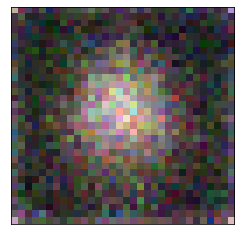

In [10]:
# Params
Nlay = 1

fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.set_xticks([])
ax.set_yticks([])

mm = ml[0][0]
for l in range(1,Nlay):
  mm = mm@ml[l][0]

hmmap = np.reshape(np.sum(mm, axis=1),(DDc,DDh,DDw))
hmmap = np.stack([hmmap[i] for i in range(3)], axis=-1)
hmmap /= np.max(hmmap)
ax.imshow(hmmap, aspect='auto', interpolation='none')

### Masks (weighted)

Plotting connectivity masks (or weighted masks) for some of the nodes.

- Nlay is the layer we want to plot the masks of
- Nplot is the number of masks
- Ncol the number of columns to arrange the plots
- Typ can be either 'm' to visualize masks, or 'wm' to visualize masks multiplied by the weights
- Step (only for weighted masks) is the step of weights to be used in the visualization (defaults to -1)
- Ord is the order we want to use to select which nodes to visualize:
    - 'last' = most connected
    - 'first' = least connected (at least 2 connections)
    - 'sample' = equispaced sample in the number of connections
- indz can be alternatively defined as a custom list of indices

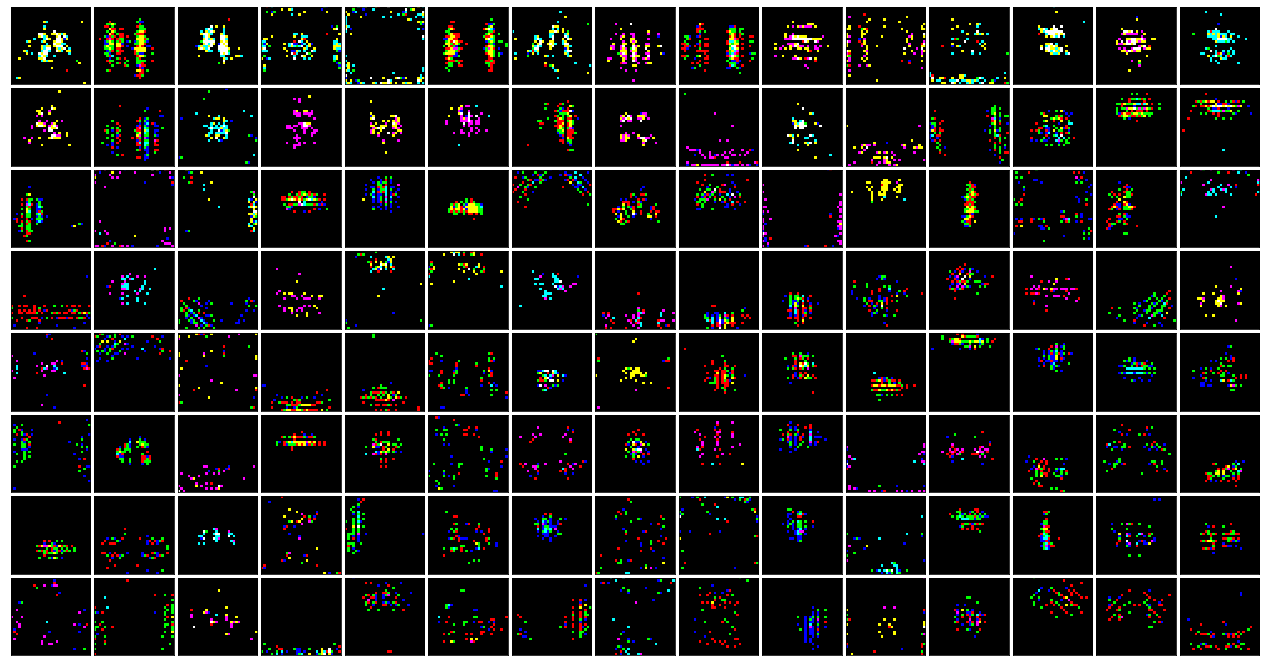

In [11]:
# Params
Nlay = 1
Nplot = 120
Ncols = 15
Typ = 'm'
Step = -1
Ord = 'last'

Nrows = int(np.ceil(Nplot/Ncols))
SIZE = 1.2
fig, ax = plt.subplots(Nrows,Ncols, figsize=(SIZE*Ncols, SIZE*Nrows))
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.05)

mm = ml[0][0]
cw = weil[Step][0][0]*ml[0][0]
for l in range(1,Nlay):
  cw = cw@(weil[Step][l][0]*ml[l][0])
  mm = mm@ml[l][0]
  
Nnei = np.asarray([len(np.nonzero(spc)[0]) for spc in mm.T])
Mnei = np.argsort(Nnei)
Mnei = Mnei[np.where(Nnei[Mnei]>1)[0]]
if Ord=='last':
  indz = Mnei[-1:-Nplot-1:-1]
elif Ord=='first':
  indz = Mnei[:Nplot]
elif Ord=='sample':
  indz = Mnei[np.arange(len(Mnei)-1,-1,-(len(Mnei)-1)/(Nplot-1)).astype(np.int32)]
# Or set it custom
# indz = ...

for i, spn in enumerate(indz):
  if Typ=='m':
    mask = np.reshape(np.reshape(mm[:,spn],(DDc,-1)).T,(DDh,DDw,DDc))
    mask = np.clip(mask,0,1)
  elif Typ=='wm':
    mask = np.reshape(np.reshape(mm[:,spn]*cw[:,spn],(DDc,-1)).T,(DDh,DDw,DDc))
    mask -= np.min(mask)
    mask /= np.max(mask)
  ax[i//Ncols,i%Ncols].imshow(mask, aspect='auto', interpolation='none')
  ax[i//Ncols,i%Ncols].set_xticks([])
  ax[i//Ncols,i%Ncols].set_yticks([])

## Validating the network
Actually loading the data and weights and re-evaluating the network or its variations

### Loading the data
Requires path to the dataset files and desired validation size.
The mapping to our "meaningful" 10 classes is also available.

In [12]:
#Params
dataset_dir = "../ImageNet"
eval_size = 10000

norm = 1./255
tmp = unpickle(dataset_dir+"/train_data_batch_1")
mean_in = tmp['mean'].astype(np.float32)
tmp = unpickle(dataset_dir+"/val_data") #50k test data
e_in = np.reshape(norm*(np.asarray(tmp['data'][:eval_size], dtype=np.float32)-mean_in), (-1,3,32,32))
e_lab = np.asarray(tmp['labels'][:eval_size])-1
i2imap = np.asarray([1,0,0,0,0,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,1,1,1,0,0,0,1,0,1,0,0,0,1,1,0,1,1,1,1,0,0,0,1,0,0,0,1,0,0,0,1,1,1,1,0,1,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1,1,1,1,0,1,0,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,1,1,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,1,1,1,1,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,1,0,1,1,0,1,0,1,0,0,1,1,1,0,0,0,1,0,1,1,1,0,1,1,0,0,1,0,0,1,1,1,1,1,1,1,4,5,7,6,5,3,3,3,5,4,8,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,4,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,9,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,8,8,9,9,9,9,9,9,9,9,9,9,8,8,8,8,4,8,8,8,8,8,8,8,8,4,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,6,6,6,6,6,6,6,6,6,6,6,8,8,8,8,6,6,8,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,8,8,8,8,8,8,8,8,8,8,8,8,8,7,5,6,9,5,6,6,8,9,6,5,6,5,5,6,6,5,6,6,6,6,8,7,5,8,6,5,5,8,5,6,5,5,5,5,5,6,5,5,9,5,6,6,5,6,6,8,5,6,5,5,8,8,5,5,5,8,9,5,8,6,9,5,9,6,8,8,5,9,8,5,6,6,6,9,6,8,6,5,8,9,8,6,8,6,5,5,6,5,5,5,6,5,6,6,6,6,8,5,6,6,9,5,8,8,5,5,5,5,8,6,8,8,8,9,8,9,8,5,5,9,5,6,6,5,5,8,6,6,6,9,8,6,5,5,7,9,6,8,8,7,9,9,6,6,6,8,9,9,5,5,6,5,8,6,5,7,5,6,6,8,6,9,5,5,5,8,6,5,6,6,5,5,7,6,9,8,6,5,5,6,6,6,9,6,9,5,8,5,6,5,5,6,5,9,6,6,9,5,6,8,8,5,6,6,6,8,9,6,8,7,6,6,6,5,7,6,6,6,5,5,8,9,6,5,5,5,8,8,5,5,6,5,6,8,9,6,8,5,5,6,5,5,5,6,9,8,6,8,6,8,5,8,6])

## Computing the network
Same iteration loaded before, Step (default -1) is the step of weights to load if multiple are available

In [13]:
# Params
Step = -1

def evnet(arch, conf, ml, mvl, data):
  batchN = np.shape(data)[0]
  eps = 1e-10
  act = np.reshape(data,(batchN,-1))
  for l, (typ, par, _) in enumerate(arch):
    W = conf[l][0]
    b = conf[l][1]
    gamma = conf[l][2]
    beta = conf[l][3]
    act = gamma*( (act-mvl[l][0]) / np.sqrt(mvl[l][1]+eps) ) + beta
    act = act@(W*ml[l][0]) + b*ml[l][1]
    if typ=='f':
      act = np.maximum(act,0)
  act = np.exp(act-np.max(act,axis=1)[:,np.newaxis])
  act = act/np.sum(act,axis=1)[:,np.newaxis]
  return act

probs = evnet(arch, weil[Step], ml, mvl[Step], e_in)
labs = np.argmax(probs, axis=1)
top5 = np.argpartition(probs, -5, axis=1)[:,-5:]
print("Model evaluated with weights at iteration {}.".format(Tpoints[Step]))
print("Top-1 accuracy: {:.2f}%".format(100*len(np.where(labs==e_lab)[0])/eval_size))
print("Top-5 accuracy: {:.2f}%".format(100*len(np.where(np.any(top5==e_lab[:,np.newaxis],axis=1))[0])/eval_size))

Model evaluated with weights at iteration 100000.
Top-1 accuracy: 11.63%
Top-5 accuracy: 25.46%


## Evaluating masked network

Completely masking away some nodes and re-evaluating the network.

- Mode can be 'max' (most connections), 'min' (least connections), or 'rand' (random)
- Sizes is a list of number of nodes to be removed

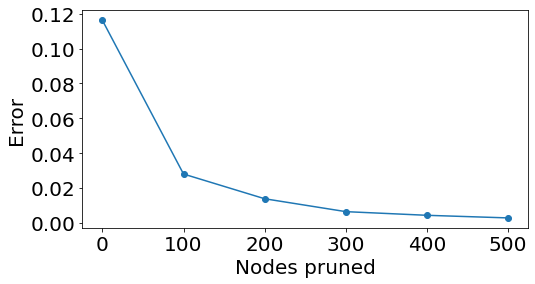

In [14]:
Mode = 'max'
Sizes = np.arange(0,501,100)

Nnei = np.asarray([len(np.nonzero(spc)[0]) for spc in ml[0][0].T])
Mnei = np.argsort(Nnei)

vals = []
for s in Sizes:
  mlm = copy.deepcopy(ml)
  if s>0:
    if Mode=='max':
      for i in Mnei[-s:]:
        mlm[0][0][:,i] = 0
    elif Mode=='min':
      for i in Mnei[:s]:
        mlm[0][0][:,i] = 0
    elif Mode=='rand':
      for i in np.random.choice(len(Mnei),s,replace=False):
        mlm[0][0][:,i] = 0
  probs = evnet(arch, weil[Step], mlm, mvl[Step], e_in)
  labs = np.argmax(probs, axis=1)
  err = len(np.where(labs==e_lab)[0])/eval_size
  vals.append(err)

fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.set_xlabel(r"Nodes pruned", fontsize=20)
ax.set_ylabel(r"Error", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.plot(Sizes, vals,'o-')